# Bin Packing Lab

- Authors:
  - Adam Podolak, podola2@mcmaster.ca
  - Justin Ho, hoj66@mcmaster.ca
- Group ID on Avenue: binpack 25
- Gitlab URL: https://gitlab.cas.mcmaster.ca/podola2/l2-bin-packing

## T1: Understand The Code Base

#### Explanation of SOLID Principles

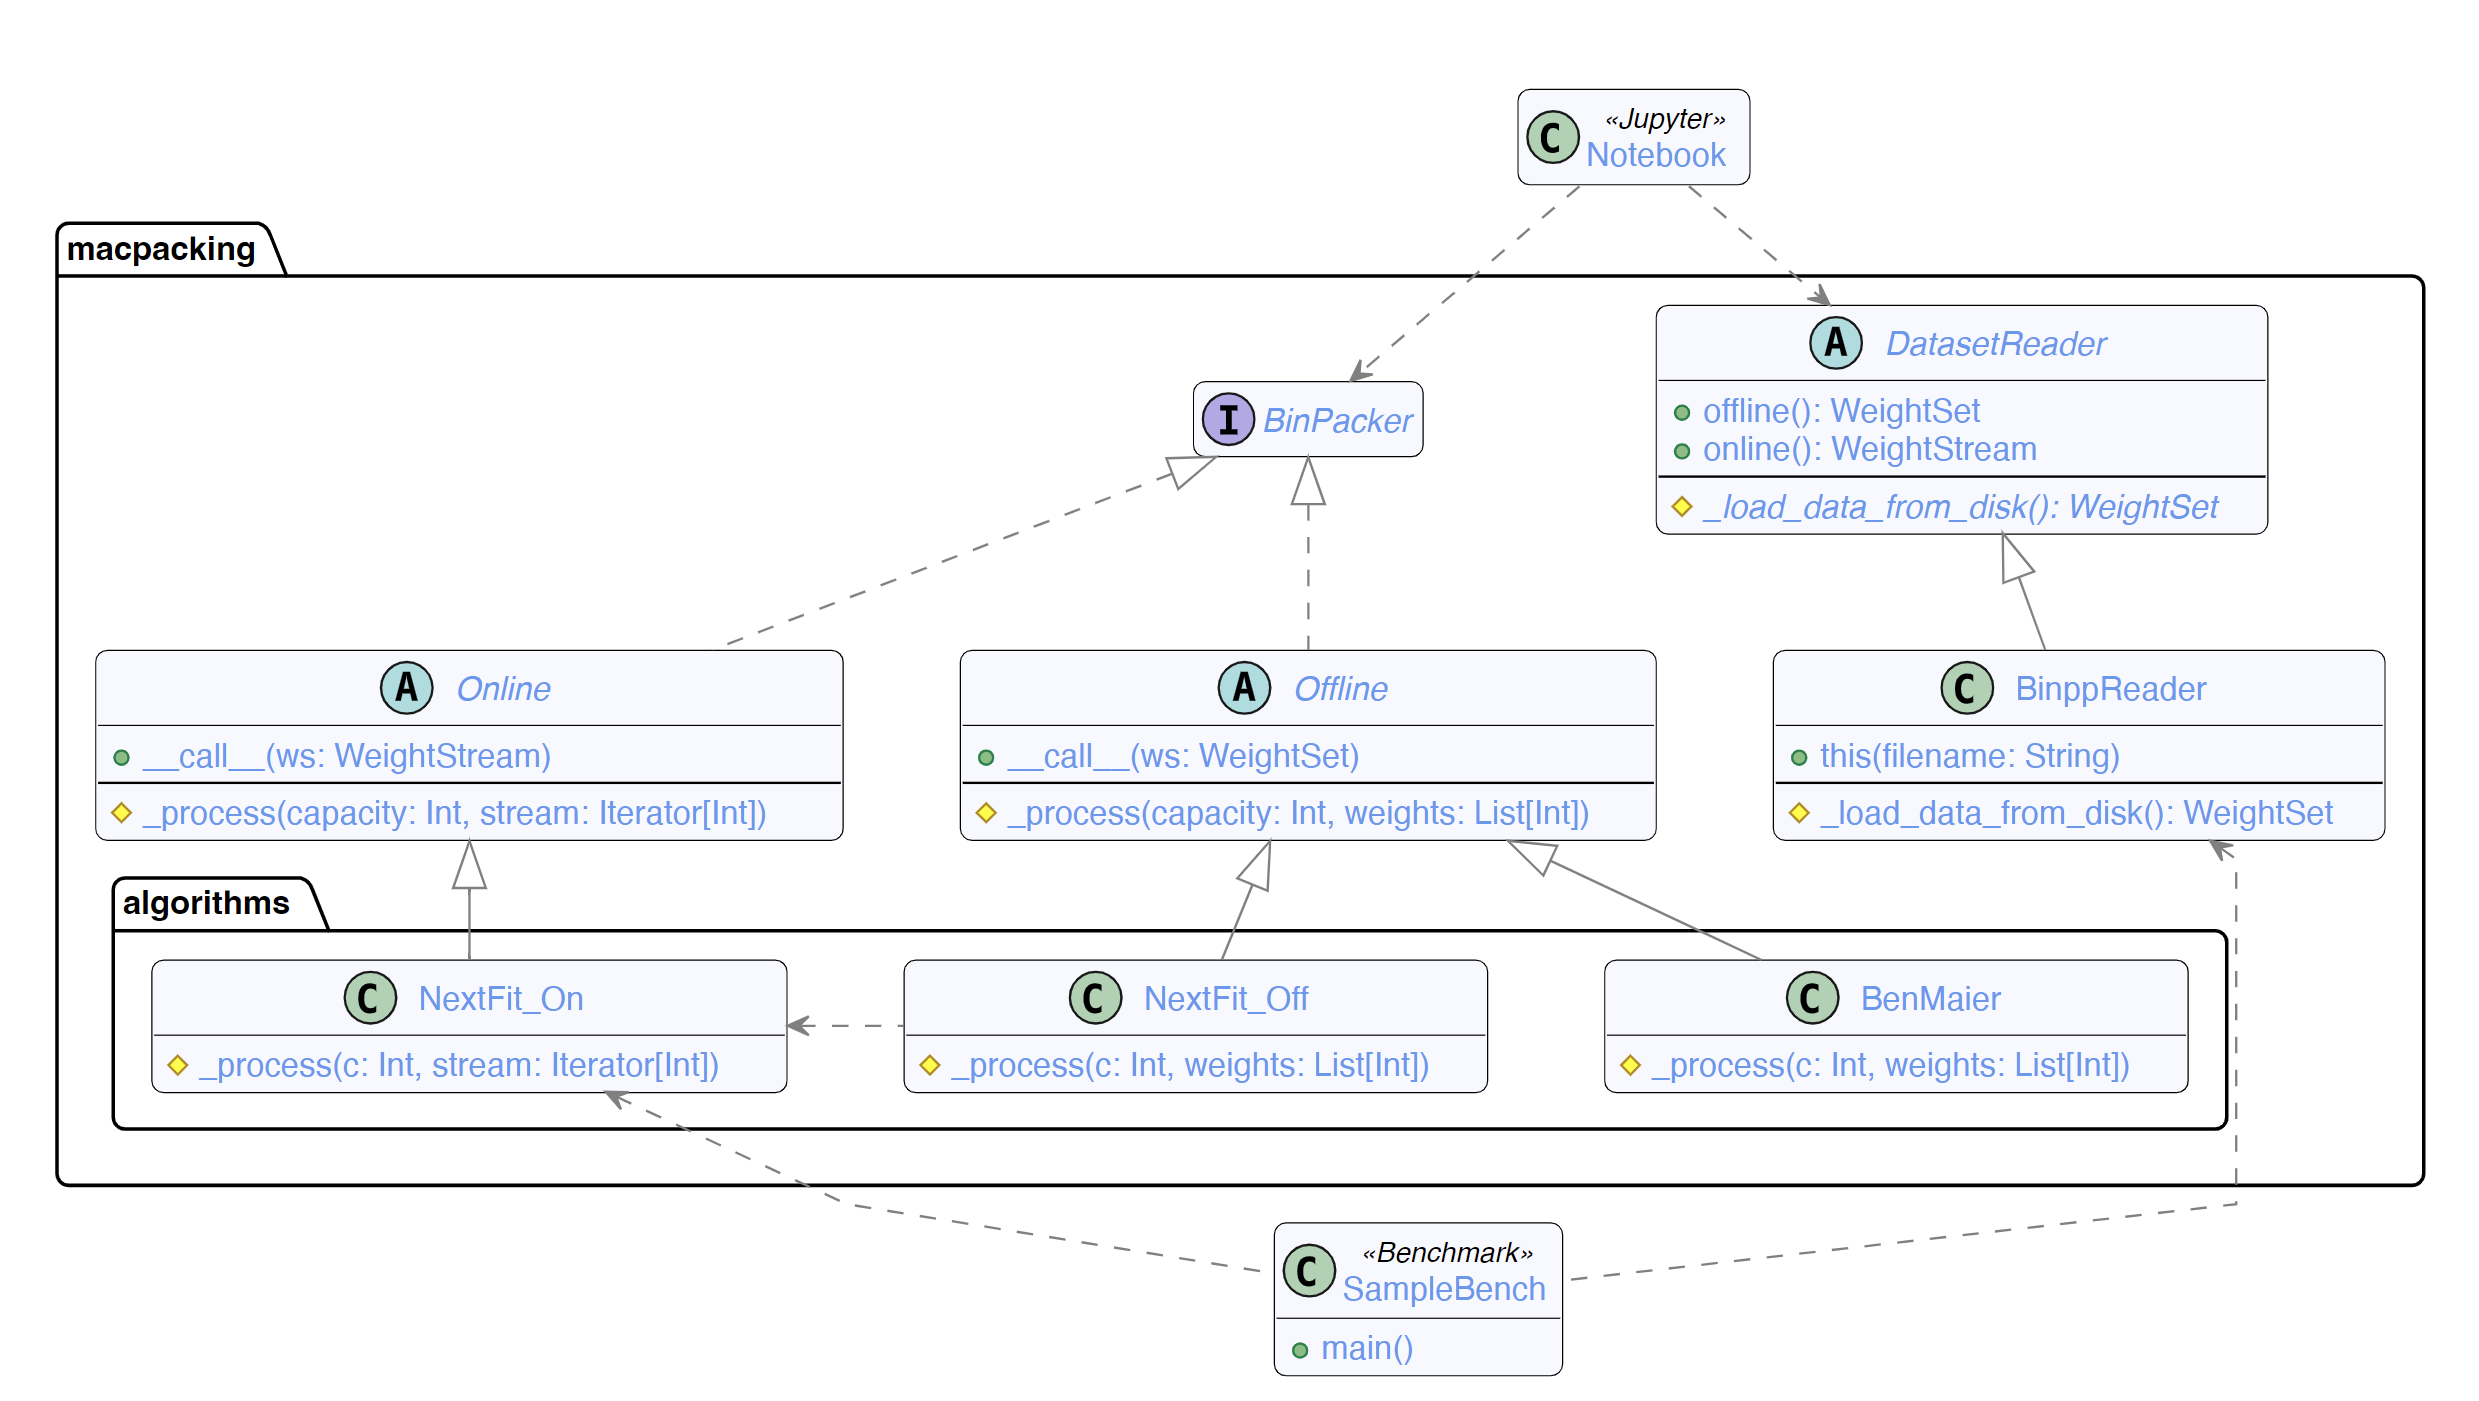

##### Single Responsibility

The single responsibility principle states that classes should have one and only one responsibility/functionality. The provided code follows this principle quite effectively. Take the abstract DatasetReader class and associated subclasses as examples. The DatasetReader class and subclasses have one main functionlity: process cases and return a weightStream or weightSet (as well as capacity) to support either an online or offline algorithm respectively. In a similar fashion, Online and Offline abstract classes and associated subclasses have the functionality of processing a weightStream or weightSet and return a Solution: list[list[int]].

##### Open-Closed Principle

The open-closed principle refers to objects being 'open for extension' but 'closed for modification'. The provided code does this with the use of abstract classes, interfaces, and effective association relationships. Once again let's look at a concrete example from the above UML. Take the DatasetReader abstract class as an example. The DatasetReader class is open for extension and closed for modification because new 'concrete' DatasetReaders can be added without modifying the original structure of the code. In this instance, the notion of reading data is entirely encapsulated. If the format of a case file changes, a new DatasetReader can be instantiated to support this new file format, and the DatasetReader can still accomplish its objective of producing input types that support the functionalities of the Offline and Online classes. The same goes for the Online and Offline classes, where the notion of 'binpacking' is encapsulated. New 'binpackers' can be created without changing the definition of what a Binpacker is, and still produce a Solution in the end.

##### Interface Segregation

The interface segragation principle states that classes don't/shouldn't depend on methods that they don't use. We see this to be true for the provided code through the use of abstract methods in the Offline, Online, and DatasetReader abstract classes. Concrete classes associated with these abstract classes only depend and implement the abstract methods of their superclass. For example, the BinppReader does not depend on the offline() and online() methods of the DatasetReader.

##### Dependancy Inversion

Dependancy inversion is a principle that states higher level classes should not depend on lower level classes. The higher level classes should depend on abstractions of the lower level ones. We see this visually in the UML, where all association and dependancy arrows only face upwards towards higher level classes. No interface or high level abstract class depends on its lower level subclasses. The abstract methods within each abstract class allow for high level entities to be completely independent of lower level ones. The high level classes are not concerned with the details of their abstract methods, meaning low level classes can implement them however they wish and still preserve the functionalities of the higher level class. We see this in the Offline and Online classes, where concrete online/offline algorithms can process cases differently, but the high level entity is not concerned with how they do this as long as a Solution is returned.


#### Dataset Explanation

Each dataset has a simimlar structure. The binpp datasets are formatted as follows: The first line contains the number of items that need to be 'packed' into bins. The second line provides the capacity (the maximum sum of weights) for each bin. The remaining lines provide the weights of each object. The jburkardt dataset is similar, however it does not provide the number of items and list the capacity and object weights in seperate files. 

The dimensions used for the dataset are represented with the naming convention NxCyWz_v.B. Where x represents the number of items, x = (1,2,3,4) -> n = (50, 100, 200, 500), y represents the capacity for a bin where y = (1,2,3) -> (100,120,150) and z represents the possible weight ranges z = (1,2,3) -> (1-100, 20-100, 30-100). These dimensions allow us to evaluate different bin packing algorithms with respect to changes in capacity, number of items, and weight possibilities. It helps us answer questions like: How will these algorithms perform with a larger number of objects? How will these algorithms behave larger/smaller weights for each object? How does varying capacity possibly change the number of bins used? Being able to answer these questions about each individual algorithm can help us compare the performances of different offline and online algorithms with respect to predefined KPIs.

## T2: Implement and Benchmark Algorithms

#### Benchmarking Protocol and Results

##### Imports

In [ ]:
from macpacking.algorithms.online import NextFit as Nf_online, BestFit, WorstFit, TerriblePacker, FirstFit
from macpacking.algorithms.offline import NextFit as Nf_offline, FirstFitDecreasing, BestFitDecreasing, WorstFitDecreasing 
from macpacking.algorithms.baseline import BenMaier
from macpacking.reader import BinppReader
from os import listdir
from os.path import isfile, join, basename
import json
from pyperf import BenchmarkSuite
from benchmark import Benchmark
from string import ascii_uppercase
import numpy as np
import matplotlib.pyplot as plt
import csv

: 

##### Retrieving the Benchmark Results

In [ ]:
benchfile = 'benchResults.json'
bench = Benchmark()
algorithms = bench.algos
dataset = bench.CASES
foldername = dataset.split('/')[-1] + '_'
num_cases = len(bench.list_case_files(dataset))

def generate_benchnames(foldername: str, algo_name: str, num_cases: int):
    names: list[str] = []
    for i in range(num_cases):
        names.append(foldername + ascii_uppercase[i] + '.BPP.txt-' + algo_name)
    return names

def get_avg_runtime(filename: str, bench_name: str):
    suite = BenchmarkSuite.load(filename)
    bench = suite.get_benchmark(bench_name)
    bench_result = list(bench.get_values())
    #calculates average of all runs
    s = sum(bench_result)
    l = len(bench_result)
    return s/l

def get_bench_results():
    results = {}
    for a in algorithms:
        benchnames = generate_benchnames(foldername, a, num_cases)
        for name in benchnames:
            results[name] = get_avg_runtime(benchfile, name) 
    return results
        
results = get_bench_results()
#print(json.dumps(results, indent=4, sort_keys=False))

: 

##### Storing Online Results

In [ ]:
nf_online = [results[name] for name in results if name.endswith('nf-online')]
bf_online = [results[name] for name in results if name.endswith('bf-online')]
wf_online = [results[name] for name in results if name.endswith('wf-online')]
ff_online = [results[name] for name in results if name.endswith('ff-online')]

: 

##### Storing Offline Results

In [ ]:
nf_offline = [results[name] for name in results if name.endswith('nf-offline')]
bf_offline = [results[name] for name in results if name.endswith('bf-offline')]
wf_offline = [results[name] for name in results if name.endswith('wf-offline')]
ff_offline = [results[name] for name in results if name.endswith('ff-offline')]
bf_offline[18] = 0.006718469687500001 #case S had an unexpected deviation way bigger than normal

: 

##### Storing Results for Baseline and Terrible 

In [ ]:
terrible = [results[name] for name in results if name.endswith('terrible')]
baseline = [results[name] for name in results if name.endswith('baseline')]

: 

##### Plotting Execution Times

In [ ]:
x = [i for i in range(num_cases)]
x = np.arange(len(x))

#runtimes for online algorithms
plt.rcParams["figure.figsize"] = [20, 5]
plt.bar(x - 0.3, nf_online, 0.15, label = 'NextFit(Online)')
plt.bar(x - 0.15, bf_online, 0.15, label = 'BestFit(Online)')
plt.bar(x, wf_online, 0.15, label = 'WorstFit(Online)')
plt.bar(x + 0.15, ff_online, 0.15, label = 'FirstFit(Online)')
plt.bar(x + 0.3, terrible, 0.15, label = 'Terrible(Online)')

plt.xticks(x, (ascii_uppercase[i] for i in range(num_cases)))
plt.title("Online Algorithm Execution Time")
plt.xlabel('Cases')
plt.ylabel('Time')
plt.legend()
plt.show()

: 

In [ ]:
x = [i for i in range(num_cases)]
x = np.arange(len(x))

#runtimes for offline algorithms
plt.rcParams["figure.figsize"] = [20, 5]
plt.bar(x - 0.3, bf_offline, 0.2, label = 'BestFit(Offline)')
plt.bar(x - 0.1, wf_offline, 0.2, label = 'WorstFit(Offline)')
plt.bar(x + 0.1, ff_offline, 0.2, label = 'FirstFit(Offline)')
plt.bar(x + 0.3, nf_offline, 0.2, label = 'NextFit(Offline)')


plt.xticks(x, (ascii_uppercase[i] for i in range(num_cases)))
plt.title("Offline Algorithm Execution Times")
plt.xlabel('Cases')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

: 

#### Measuring KPIs

##### Average Number of Bins

In [ ]:
from macpacking.algorithms.online import NextFit as Nf_online, BestFit, WorstFit, TerriblePacker, FirstFit
from macpacking.algorithms.offline import NextFit as Nf_offline, FirstFitDecreasing, BestFitDecreasing, WorstFitDecreasing 
from macpacking.algorithms.baseline import BenMaier
from macpacking.reader import BinppReader
from os import listdir
from os.path import isfile, join, basename

dataset = '_datasets/binpp/N1C1W1'
cases = sorted([f'{dataset}/{f}' for f in listdir(dataset) if isfile(join(dataset, f))])

algorithms = {
       'terrible': TerriblePacker(),
       'nf-online': Nf_online(),
       'bf-online': BestFit(),
       'wf-online': WorstFit(),
       'ff-online': FirstFit(),
       'nf-offline': Nf_offline(),
       'bf-offline': BestFitDecreasing(),
       'wf-offline': WorstFitDecreasing(),
       'ff-offline': FirstFitDecreasing(),
       'baseline': BenMaier()
   }

avg_num_bins = {}

for a in algorithms:
    num_bins = []
    
    for case in cases:
        
        online_input = BinppReader(case).online()
        offline_input = BinppReader(case).offline()
        
        if a == 'terrible' or a.endswith('online'):
            result = algorithms[a](online_input)
            num_bins.append(len(result))
        
        else:
            result = algorithms[a](offline_input)
            num_bins.append(len(result))
    
    avg_num_bins[a] = sum(num_bins)//len(num_bins)   

: 

In [ ]:
x = np.arange(1)
y = avg_num_bins
plt.rcParams["figure.figsize"] = [15, 7.5]
plt.bar(x - 0.9, y['terrible'], 0.2, label = 'Terrible')
plt.bar(x - 0.7, y['nf-online'], 0.2, label = 'NextFit(Online)')
plt.bar(x - 0.5, y['nf-offline'], 0.2, label = 'NextFit(Offline)')
plt.bar(x - 0.3, y['wf-online'], 0.2, label = 'WorstFit(Online)')
plt.bar(x - 0.1, y['ff-online'], 0.2, label = 'FirstFit(Online)')
plt.bar(x + 0.1, y['ff-offline'], 0.2, label = 'FirstFit(Offline)')
plt.bar(x + 0.3, y['bf-online'], 0.2, label = 'BestFit(Online)')
plt.bar(x + 0.5, y['bf-offline'], 0.2, label = 'BestFit(Offline)')
plt.bar(x + 0.7, y['wf-offline'], 0.2, label = 'WorstFit(Offline)')
plt.bar(x + 0.9, y['baseline'], 0.2, label = 'Baseline')

plt.xticks(x, '')
plt.title("Average Number of Bins Used")
plt.xlabel('Algorithms')
plt.ylabel('Average Number of Bins')
plt.legend()
plt.show()

: 

##### Average Space Remaining

In [ ]:
dataset = '_datasets/binpp/N1C1W1'
cases = sorted([f'{dataset}/{f}' for f in listdir(dataset) if isfile(join(dataset, f))])

algorithms = {
       'terrible': TerriblePacker(),
       'nf-online': Nf_online(),
       'bf-online': BestFit(),
       'wf-online': WorstFit(),
       'ff-online': FirstFit(),
       'nf-offline': Nf_offline(),
       'bf-offline': BestFitDecreasing(),
       'wf-offline': WorstFitDecreasing(),
       'ff-offline': FirstFitDecreasing(),
       'baseline': BenMaier()
   }

avg_space_remaining_in_bins = {}

def get_avg_space(binpacker_result: list[list[int]], capacity:int):
    s = 0
    for b in binpacker_result:
        s += capacity - sum(b)
    return s/len(binpacker_result)

for a in algorithms:
    
    avg_space = []
    
    for case in cases:
        
        online_input = BinppReader(case).online()
        offline_input = BinppReader(case).offline()
        capacity = offline_input[0]
        
        if a == 'terrible' or a.endswith('online'):
            result = algorithms[a](online_input)
            avg_space.append(get_avg_space(result, capacity))
        
        else:
            result = algorithms[a](offline_input)
            avg_space.append(get_avg_space(result, capacity))
    
    avg_space_remaining_in_bins[a] = sum(avg_space)//len(avg_space)

: 

In [ ]:
x = np.arange(1)
y = avg_space_remaining_in_bins
plt.rcParams["figure.figsize"] = [15, 7.5]
plt.bar(x - 0.9, y['terrible'], 0.2, label = 'Terrible')
plt.bar(x - 0.7, y['nf-online'], 0.2, label = 'NextFit(Online)')
plt.bar(x - 0.5, y['nf-offline'], 0.2, label = 'NextFit(Offline)')
plt.bar(x - 0.3, y['wf-online'], 0.2, label = 'WorstFit(Online)')
plt.bar(x - 0.1, y['ff-online'], 0.2, label = 'FirstFit(Online)')
plt.bar(x + 0.1, y['ff-offline'], 0.2, label = 'FirstFit(Offline)')
plt.bar(x + 0.3, y['bf-online'], 0.2, label = 'BestFit(Online)')
plt.bar(x + 0.5, y['wf-offline'], 0.2, label = 'WorstFit(Offline)')
plt.bar(x + 0.7, y['bf-offline'], 0.2, label = 'BestFit(Offline)')
plt.bar(x + 0.9, y['baseline'], 0.2, label = 'Baseline')

plt.xticks(x, '')
plt.title("Average Space Remaining in Bins")
plt.xlabel('Algorithms')
plt.ylabel('Average Space Remaining')
plt.legend()
plt.show()

: 

#### Algorithm Analysis

To start off, the results of the KPI's and benchmarking show that offline algorithms used less bins and had smaller average space remaining in each bin compared to their online counterparts. This was surprising since both the online and offline versions of an algorithm are performing the same actions. The difference comes from the descending order of object size in which the offline algorithm retrieves objects, compared to the online version which accesses objects in a random shuffled order. This differnce impacts which objects get placed into boxes first, which in turn changes the orientation of each box in the end.

In terms of runtime, the offline algorithm runs signifcantly slower its online versions. This difference is most likely because the offline version requires the retreival of objects from the object list to be in the reverse order of in terms of size. This means that the offline version needs to sort its objects before beginning the process of organizing it into bins, wheras the online version immedaitely begins allocating objects into bins

Looking at the execution time differences between the algorithms, we can start with best fit and worst fit. These algorithms both had similar total execution times (in their respective offline and online categories). They performed the worst in the offline sections, but were second fastest in execution time right before the terrible algorithm in the online section. The strengths of these 2 algorithms is shown when looking at the average space remaining in bins and average number of bins used. It systematically goes through all opened bins and places objects where they will fit the best(according to the criteria of best/worst fit). While this means it takes longer to add each object into a bin, it is better at utilizing the space in each bin. This can be contrasted to First fit and next Fit algorithms where once a bin is passed over, no items are placed into that bin ever again. This omits the process of going through all the bins every time a new object is retrieved, thus cutting down on execution time, but this also increases the average number of bins used and average remaining space in each bin.

The terrible bin packer is an example of an extreme algorithm that has the lowest execution time, but the highest number of bins used and highest space remaining in its bins. This algorithm is only good if you want something that runs fast, but in most realistic applications, would not be viable.






## T3: Measure Improvement Margin

#### Comparing with the Optimal Solution

##### Extracting CSV Information

In [ ]:
import csv

csv_file = '_datasets\oracle.csv'
optimal_solutions = {}

def format_csv(csv_file):
    with open(csv_file) as file:
        csv_reader = csv.reader(file, delimiter=',')
        for row in csv_reader:
            optimal_solutions[row[0]] = row[1]
    
    optimal_solutions.pop("Problem")

format_csv(csv_file)

: 

##### Runnning the Experiment

In [ ]:
from macpacking.algorithms.online import NextFit as Nf_online, BestFit, WorstFit, TerriblePacker, FirstFit
from macpacking.algorithms.offline import NextFit as Nf_offline, FirstFitDecreasing, BestFitDecreasing, WorstFitDecreasing 
from macpacking.algorithms.baseline import BenMaier
from macpacking.reader import BinppReader

dataset = '_datasets/binpp-hard'
cases = sorted([f'{dataset}/{f}' for f in listdir(dataset) if isfile(join(dataset, f))])

online_algorithms = {
       'terrible': TerriblePacker(),
       'nf-online': Nf_online(),
       'bf-online': BestFit(),
       'wf-online': WorstFit(),
       'ff-online': FirstFit()
   }

offline_algorithms = {
       'nf-offline': Nf_offline(),
       'bf-offline': BestFitDecreasing(),
       'wf-offline': WorstFitDecreasing(),
       'ff-offline': FirstFitDecreasing(),
       'baseline': BenMaier()
    }

online_results = {}
offline_results = {}

for a in online_algorithms:
    count = 0
    for case in cases:
        online_input = BinppReader(case).online()
        result = online_algorithms[a](online_input)
        online_results['HARD' + str(count) + "-" + a] = len(result)
        count += 1


for a in offline_algorithms:
    count = 0
    for case in cases:
        offline_input = BinppReader(case).offline()
        result = offline_algorithms[a](offline_input)
        offline_results['HARD' + str(count) + "-" + a] = len(result)
        count += 1

: 

##### Gathering Results

In [ ]:
nf_online = [online_results[name] for name in online_results if name.endswith('nf-online')]
bf_online = [online_results[name] for name in online_results if name.endswith('bf-online')]
wf_online = [online_results[name] for name in online_results if name.endswith('wf-online')]
ff_online = [online_results[name] for name in online_results if name.endswith('ff-online')]
nf_offline = [offline_results[name] for name in offline_results if name.endswith('nf-offline')]
bf_offline = [offline_results[name] for name in offline_results if name.endswith('bf-offline')]
wf_offline = [offline_results[name] for name in offline_results if name.endswith('wf-offline')]
ff_offline = [offline_results[name] for name in offline_results if name.endswith('ff-offline')]
terrible = [online_results[name] for name in online_results if name.endswith('terrible')] #this is trivial, so we won't add it in the comparison
baseline = [offline_results[name] for name in offline_results if name.endswith('baseline')]
optimal = [int(optimal_solutions[name]) for name in optimal_solutions]

: 

##### Plotting Results (Online)

In [ ]:
x = np.arange(len(optimal_solutions))
plt.rcParams["figure.figsize"] = [15, 7.5]
plt.bar(x - 0.25, nf_online, 0.1, label = 'NextFit')
plt.bar(x - 0.15, bf_online, 0.1, label = 'BestFit')
plt.bar(x - 0.05, wf_online, 0.1, label = 'WorstFit')
plt.bar(x + 0.05, ff_online, 0.1, label = 'FirstFit')
plt.bar(x + 0.15, baseline, 0.1, label = 'Baseline')
plt.bar(x + 0.25, optimal, 0.1, label = 'Optimal')


plt.xticks(x, [i for i in optimal_solutions])
plt.yticks(np.arange(0, 100, 5))
plt.title("Average Space Remaining in Bins")
plt.xlabel('Algorithms')
plt.ylabel('Average Space Remaining')
plt.legend()
plt.show()

: 

In [ ]:
x = np.arange(len(optimal_solutions))
plt.rcParams["figure.figsize"] = [15, 7.5]
plt.bar(x - 0.25, nf_offline, 0.1, label = 'NextFit')
plt.bar(x - 0.15, bf_offline, 0.1, label = 'BestFit')
plt.bar(x - 0.05, wf_offline, 0.1, label = 'WorstFit')
plt.bar(x + 0.05, ff_offline, 0.1, label = 'FirstFit')
plt.bar(x + 0.15, baseline, 0.1, label = 'Baseline')
plt.bar(x + 0.25, optimal, 0.1, label = 'Optimal')


plt.xticks(x, [i for i in optimal_solutions])
plt.yticks(np.arange(0, 100, 5))
plt.title("Average Space Remaining in Bins")
plt.xlabel('Algorithms')
plt.ylabel('Average Space Remaining')
plt.legend()
plt.show()

: 

#### Measurement of margin of improvement

Continuous Approach:
After comparing all results of previous algorithms with the optimal results, it is clear that the algorithms do not fully optimize the space in each bin. As shown in the above graphs, all algorithms produce results slightly higher than the optimal solution. 

Nextfit and FirstFit performed the worst compared to the optimal solution, since the difference between the average space remaining(ASR) and average bins used(ABU) are the greatest compared to the optimal solution. 

WorstFit, BestFit, and the baseline come the closest to the optimal result, but can still improve.

The problem most likely that all the algorithms do not have repeated access to objects that they interact with (i.e. they cannot pick up objects they have placed into a bin). This prevents any algorithm from finding the perfect organization of objects in each bin that would match the optimal result. 

#### Problematic cases

Each algorithm needs the object list to be organized in a certain order so that retrieval is the most optimal with respect to how it places objects into bins. Since these lists are shuffled, the gap between optimal and actual results becomes greater as the difference between the ideal and shuffled list increases. 

FirstFit and NextFit algorithms want object lists where retrieval of the next object will fill up the current bin as much as possible. These algorithms are unable to place objects in previous bins, thus the next object retrieval must fill up current bin as much as possible.

The BestFit and WorstFit algorithms benefit off the same object list as FirstFit and NextFit but is more leniant with the order, since it can place objects into any previously openned boxes. 

For all algorithms, they might place an object into a bin when it may have been better to place it with other objects in another bin. All algorithms are incapable of accounting for this, so the order of the object list must be positioned in a specific way if the optimal result is desired.


## T4: Add Smarter Algorithms

## T5: From Fixed Capacity to Fixed Bins

: 

#### Adequete KPI's

Due to the nature of this specific problem, the execution time of each algorithm is the only KPI that is useful from our original list of KPI's. The other KPI's (average remaining space in bins and average number of bins used) are not applicable because this problem applies to a fixed number of bins with unlimited space. But, we can modify the unused KPI's to create new benchmarks because the situations are similar. For example, the "average remaining space in bins" KPI can be modified to track the space difference between each bin. The result can be compared to other solutions to determine which algorithm best distributes its objects evenly.

## Self-reflection questions

As part of the self-reflection dimension of an experiential course, each member of the group is expected to answer to the following four questions:

  - What process did you go through to produce this result? (Backward)
  - What were your standards for this piece of work? Did you meet your standards? (Inward)
  - What the one thing you particularly want people to notice when they look at your work? (Outward)
  - What lessons will you keep from this reading/lecture in your professional practice? (Forward)